In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
from sklearn.model_selection import train_test_split

In [2]:
def load_data(filetype='sql'):
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    data.replace([1.1e+308], np.nan, inplace=True)
    data.fillna(np.nan, inplace=True)
    #data['timestamp'] -= data['timestamp'].min()
    #data = data.replace([np.nan], 0)
    #data = (data - data.mean())/data.std()
    return data

In [3]:
data = load_data('csv')

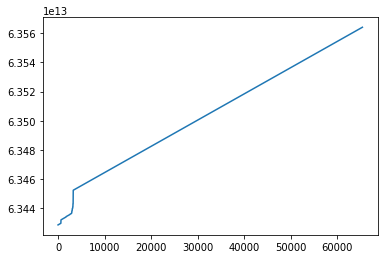

In [4]:
plt.plot(data['timestamp'])

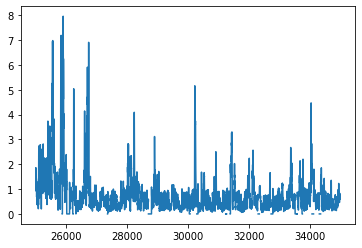

In [5]:
plt.plot(data['RMS_VE'][25000:35000])

In [6]:
torch.from_numpy(data.values)

tensor([[6.3428e+13,        nan,        nan,  ...,        nan,        nan,
                nan],
        [6.3428e+13,        nan,        nan,  ...,        nan,        nan,
                nan],
        [6.3428e+13,        nan,        nan,  ...,        nan,        nan,
                nan],
        ...,
        [6.3564e+13,        nan,        nan,  ...,        nan,        nan,
                nan],
        [6.3564e+13,        nan,        nan,  ...,        nan,        nan,
                nan],
        [6.3564e+13,        nan,        nan,  ...,        nan,        nan,
                nan]], dtype=torch.float64)

In [7]:
num_epochs=10
batch_size=100
learning_rate=1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
tensor_data = torch.tensor(data['RMS_VE'][25000:35000].values.astype(np.float32))
load = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [9]:
for idx, item in enumerate(load):
    print(idx, item.view(-1,len(item)))
    break

0 tensor([[1.2511, 1.1271, 1.8600, 1.2282, 1.5207, 1.2647, 1.1400, 1.2847, 1.0171,
         1.4057, 1.3552, 1.1208, 1.1660, 1.1384, 1.1471, 0.9407, 0.9383, 1.0409,
         1.4231, 0.9323, 1.1629, 1.0826, 1.0511, 0.9068, 0.9876, 1.3208, 1.0522,
         0.8705, 0.6813, 0.8923, 0.9470, 1.1603, 0.9544, 0.9846, 0.9245, 1.2407,
         1.1755, 1.1780, 1.0732, 1.0021, 0.8782, 0.8179, 0.3731, 0.5246, 0.3795,
         0.4737, 0.8632, 0.7981, 0.6389, 0.7082, 0.9093, 0.6802, 1.0034, 0.9509,
         1.0199, 0.9199, 0.8684, 0.9347, 1.0726, 0.9452, 1.0120, 1.0657, 1.0017,
         0.9384, 1.0099, 1.0713, 1.1380, 0.9822, 0.8211, 0.9539, 0.8267, 0.9783,
         0.8633, 0.7762, 0.5450, 0.8740, 0.4254, 0.3957, 0.4366, 0.5874, 0.3538,
         0.2721, 0.4339, 0.2089, 0.4943, 0.8820, 0.3481, 0.4344, 0.3692, 0.6360,
         0.6712, 0.7660, 1.1150, 1.3249, 1.7295, 2.1041, 2.0530, 2.1517, 2.7353,
         2.4007]])


In [10]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 100)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [154]:
model = AutoEncoder()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []

for epoch in range(num_epochs):
    #item = item.to(device)
    for idx, item in enumerate(load):
        # forward
        item = item.view(len(item), -1)
        output = model(item)
        loss = loss_func(output, item)
        
        # backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_list.append(loss)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 128x62)